<a href="https://colab.research.google.com/github/fbeilstein/dbms/blob/master/DB_lecture_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementing B-Trees**


* First, we discuss organization: how to establish relationships between keys and pointers, and how to implement headers and links between pages.
* Next, we discuss processes that occur during root-to-leaf descends, namely how to perform binary search and how to collect breadcrumbs and keep track of parentnodes in case we later have to split or merge nodes.
* Lastly, we discuss optimization techniques (rebalancing, right-only appends, and bulk loading), maintenance processes, and garbage collection.

**Page Header**


The page header holds information about the page that can be used for navigation, maintenance, and optimizations. 

It usually contains flags that describe page contents and layout, number of cells in the page, lower and upper offsets marking the empty space (used to append cell offsets and data), and other useful metadata.

For example, **PostgreSQL** stores the page size and layout version in the header. In **MySQL InnoDB**, page header holds the number of heap records, level, and some other implementation-specific values. In **SQLite**, page header stores the number of cells and a rightmost pointer.

**Magic Numbers**


One of the values often placed in the file or page header is a magic number. 

Usually, it’s a multibyte block, containing a constant value that can be used to signal that the block represents a page, specify its kind, or identify its version.

Magic numbers are often used for validation and sanity checks. It’s
very improbable that the byte sequence at a random offset would exactly match the magic number. If it did match, there’s a good chance the offset is correct. 

For example, to verify that the page is loaded and aligned correctly, during write we can place the magic number 50 41 47 45 (hex for PAGE) into the header. During the read, we validate the page by comparing the four bytes from the read header with the expected byte sequence.

**Sibling Links**


Some implementations store **forward** and **backward** links, pointing to the left and right **sibling** pages. These links help to locate neighboring nodes without having to ascend back to the parent. This approach adds some complexity to split and merge operations, as the sibling offsets have to be updated as well. 


Unless the siblings are linked, we have to refer to the parent node. This operation might ascend all the way up to the  root, since the direct parent can only help to address its own children. If we store sibling links directly in the header, we can simply follow them to locate the previous or next node on the same level.

One of the downsides of storing sibling links is that they have to be updated during splits and merges. Since updates have to happen in a sibling node, not in a splitting/merging node, it may require additional locking.

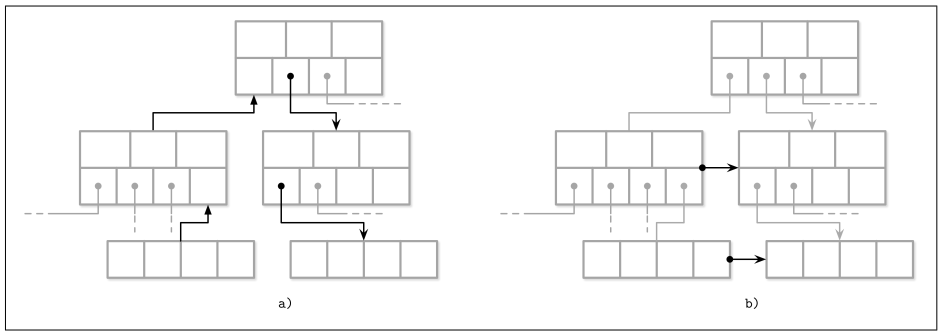

**Rightmost Pointers**


B-Tree separator keys have strict invariants: they’re used to split the tree into subtrees and navigate them, so there is always one more pointer to child pages than there are keys. 

In many implementations, nodes look more like this


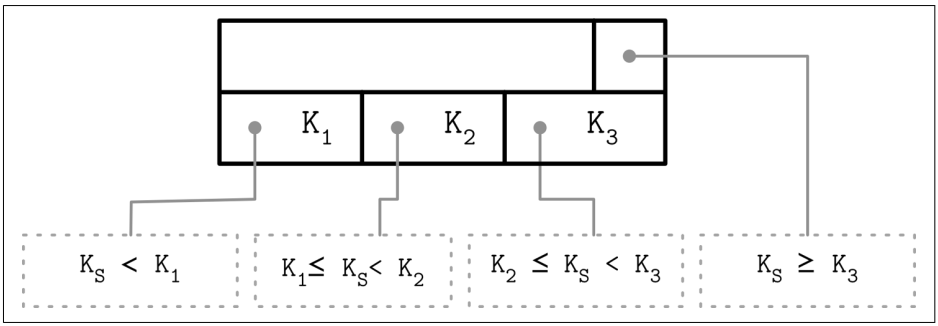

Each separator key has a child pointer, while the last pointer is stored separately, since it’s not paired with any key.  This extra pointer can be stored in the header as, for example, it is implemented in **SQLite**.


If the rightmost child is split and the new cell is appended to its parent, the rightmost child pointer has to be reassigned. After the split, the cell
appended to the parent (shown in gray) holds the promoted key and points to the
split node. The pointer to the new node is assigned instead of the previous rightmost pointer. A similar approach is described and implemented in **SQLite**.

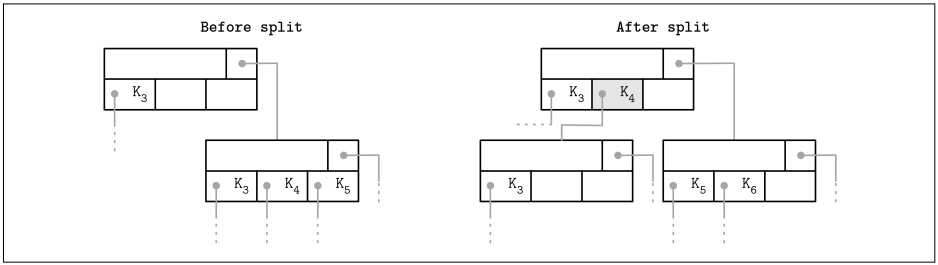

**Node High Keys**


We can take a slightly different approach and store the rightmost pointer in the cell along with the node **high key**. The **high key** represents the highest possible key that can be present in the subtree under the current node. 

This approach is used by **PostgreSQL** and is called $B^\text{link}$-Tree.

B-Trees have $N$ keys (denoted with $K_i$) and $N + 1$ pointers (denoted with $P_i$). In each subtree, keys are bounded by $K_{i-1} \leq K_s < K_i$. The $K_0 = -\infty$ is implicit and is not present in the node.

$B^\text{link}$-Trees add a $K_{N+1}$ key to each node. It specifies an upper bound of keys that can be stored in the subtree to which the pointer $P_N$ points, and therefore is an upper bound of values that can be stored in the current subtree. 

In this case, pointers can be stored pairwise, and each cell can have a corresponding pointer, which might simplify rightmost pointer handling as there are not as many edge cases to consider.

You can see schematic page structure for both approaches and how the search space is split differently for these cases: going up to $+\infty$ in the first case, and up to the upper bound of $K_3$ in the second.

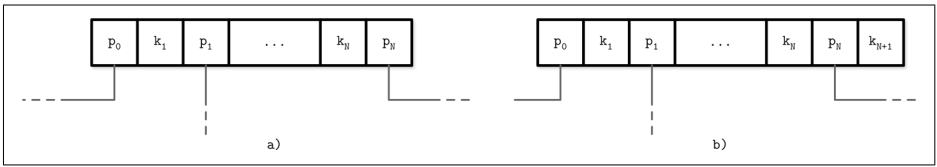

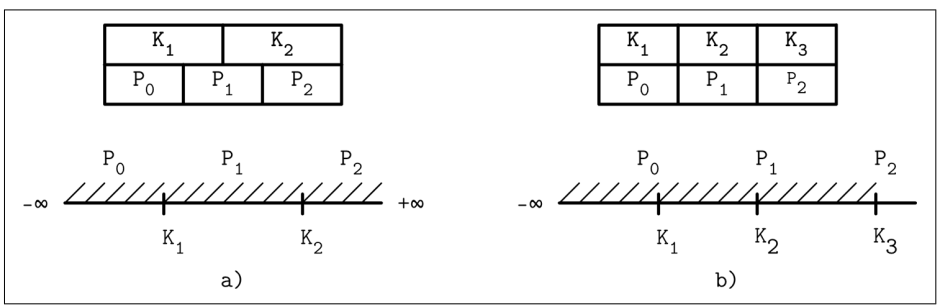

**Overflow Pages**


Node size and tree fanout values are fixed and do not change dynamically. It would also be difficult to come up with a value that would be universally optimal: if variablesize values are present in the tree and they are large enough, only a few of them can fit into the page. If the values are tiny, we end up wasting the reserved space.


The B-Tree algorithm specifies that every node keeps a specific number of items.
Since some values have different sizes, we may end up in a situation where, according to the B-Tree algorithm, the node is not full yet, but there’s no more free space on the fixed-size page that holds this node. 

Resizing the page requires copying already written data to the new region and is often impractical. However, we still need to find a way to increase or extend the page size.


To implement variable-size nodes without copying data to the new contiguous region, we can build nodes from multiple linked pages. For example, the default page size is 4K, and after inserting a few values, its data size has grown over 4 K. Instead of allowing arbitrary sizes, nodes are allowed to grow in 4 K increments, so we allocate a 4 K extension page and link it from the original one. These linked page extensions are called overflow pages. 

Most B-Tree implementations allow storing only up to a fixed number of payload
bytes in the B-Tree node directly and spilling the rest to the overflow page. This value is calculated by dividing the node size by fanout. Using this approach, we cannot end up in a situation where the page has no free space, as it will always have at least `max_payload_size` bytes. 

For more information on overflow pages in SQLite, see the **SQLite** source code repository; also check out the **MySQL InnoDB** documentation.

When the inserted payload is larger than `max_payload_size`, the node is checked for whether or not it already has any associated overflow pages. If an overflow page already exists and has enough space available, extra bytes from the payload are spilled there. Otherwise, a new overflow page is allocated.

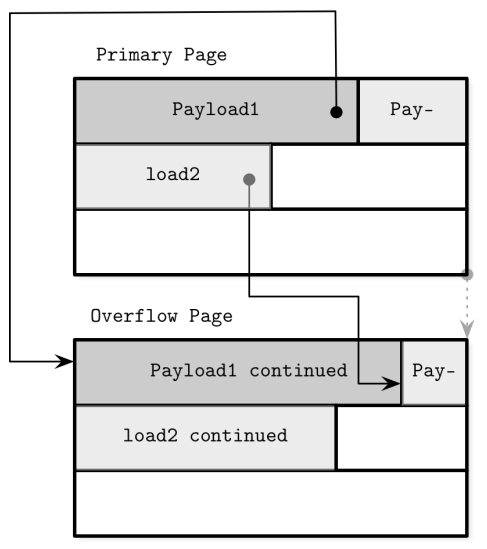

Overflow pages require some extra bookkeeping, since they may get fragmented as
well as primary pages, and we have to be able to reclaim this space to write new data, or discard the overflow page if it’s not needed anymore.

When the first overflow page is allocated, its page ID is stored in the header of the primary page. If a single overflow page is not enough, multiple overflow pages are linked together by storing the next overflow page ID in the previous one’s header. Several pages may have to be traversed to locate the overflow part for the given payload.

Since keys usually have high cardinality, storing a portion of a key makes sense, as most of the comparisons can be made on the trimmed key part that resides in the primary page.

For data records, we have to locate their overflow parts to return them to the user. However, this doesn’t matter much, since it’s an infrequent operation. If all data records are oversize, it is worth considering specialized blob storage for large values

**Binary Search**


We locate a searched key within the node using the binary search algorithm. Binary search works only for sorted data. If keys are not ordered, they can’t be binary searched. This is why keeping keys in order and maintaining a sorted invariant is essential.

The binary search algorithm receives an array of sorted items and a searched key, and returns a number. If the returned number is positive, we know that the searched key was found and the number specifies its position in the input array. 

A negative return value indicates that the searched key is not present in the input array and gives us an insertion point.

The insertion point is the index of the first element that is greater than the given key. An absolute value of this number is the index at which the searched key can be inserted to preserve order. 

Insertion can be done by shifting elements over one position, starting from an insertion point, to make space for the inserted element.


The majority of searches on higher levels do not result in exact matches, and we’re interested in the search direction, in which case we have to find the first value that is greater than the searched one and follow the corresponding child link into the associated subtree.

**Binary Search with Indirection Pointers**


Cells in the B-Tree page are stored in the insertion order, and only cell offsets preserve the logical element order. To perform binary search through page cells, we pick the middle cell offset, follow its pointer to locate the cell, compare the key from this cell with the searched key to decide whether the search should continue left or right, and continue this process recursively until the searched element or the insertion point is found.

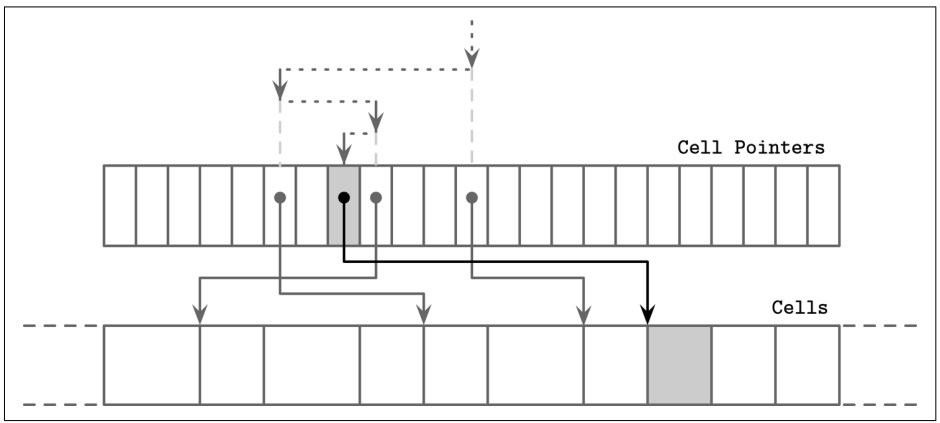

**Propagating Splits and Merges**


As we’ve discussed in previous chapters, B-Tree splits and merges can propagate to higher levels. For that, we need to be able to traverse a chain back to the root node from the splitting leaf or a pair of merging leaves.

B-Tree nodes may include parent node pointers. Just like sibling pointers, parent pointers have to be updated whenever the parent changes. This happens in all the cases when the separator key with the page identifier is transferred from one node to another: during the parent node splits, merges, or rebalancing of the parent node.

Some implementations (for example, **WiredTiger**) use parent pointers for leaf traversal to avoid deadlocks, which may happen when using sibling pointers. Instead of using sibling pointers to traverse leaf nodes, the algorithm employs parent pointers.

To address and locate a sibling, we can follow a pointer from the parent node and recursively descend back to the lower level. Whenever we reach the end of the parent node after traversing all the siblings sharing the parent, the search continues upward recursively, eventually reaching up to the root and continuing back down to the leaf level.

**Breadcrumbs**


Instead of storing and maintaining parent node pointers, it is possible to keep track of nodes traversed on the path to the target leaf node, and follow the chain of parent nodes in reverse order in case of cascading splits during inserts, or merges during deletes.

During operations that may result in structural changes of the B-Tree (insert or
delete), we first traverse the tree from the root to the leaf to find the target node and the insertion point. Since we do not always know up front whether or not the operation will result in a split or merge (at least not until the target leaf node is located), we have to collect **breadcrumbs**.

**Breadcrumbs** contain references to the nodes followed from the root and are used to backtrack them in reverse when propagating splits or merges. The most natural data structure for this is a stack. For example, **PostgreSQL** stores breadcrumbs in a stack, internally referenced as BTStack.

If the node is split or merged, breadcrumbs can be used to find insertion points for the keys pulled to the parent and to walk back up the tree to propagate structural changes to the higher-level nodes, if necessary. This stack is maintained in memory.

If the target leaf node is split, the item on top of the stack is popped to locate its immediate parent. If the parent node has enough space, a new cell is appended to it at the cell index from the breadcrumb (assuming the index is still valid). Otherwise, the parent node is split as well. This process continues recursively until either the stack is empty and we have reached the
root, or there was no split on the level.

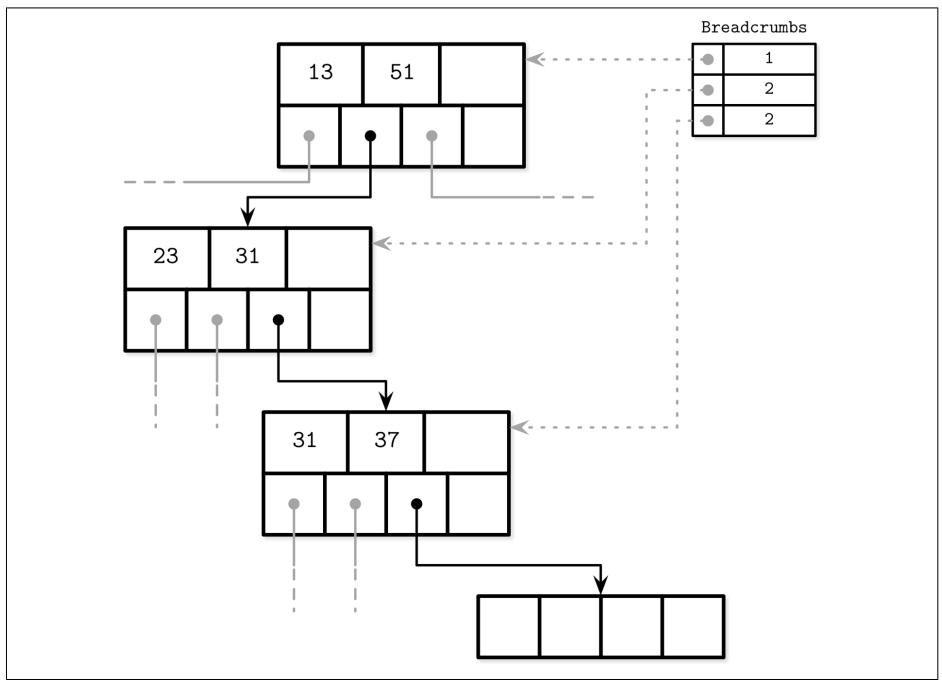

**Rebalancing**


Some B-Tree implementations attempt to postpone split and merge operations to
amortize their costs by rebalancing elements within the level, or moving elements from more occupied nodes to less occupied ones for as long as possible before finally performing a split or merge. 

This helps to improve node occupancy and may reduce the number of levels within the tree at a potentially higher maintenance cost of rebalancing.

Load balancing can be performed during insert and delete operations. To improve space utilization, instead of splitting the node on overflow, we can transfer some of the elements to one of the sibling nodes and make space for the insertion.

Similarly, during delete, instead of merging the sibling nodes, we may choose to move some of the elements from the neighboring nodes to ensure the node is at least half full.


$B^*$-Trees keep distributing data between the neighboring nodes until both siblings are full. Then, instead of splitting a single node into two half-empty ones, the algorithm splits two nodes into three nodes, each of which is two-thirds full.

**SQLite** uses this variant in the implementation. This approach improves an average occupancy by postponing splits, but requires additional tracking and balancing logic.


Higher utilization also means more efficient searches, because the height of the tree is smaller and fewer pages have to be traversed on the path to the searched leaf.

Elements from the more occupied node are moved to the less occupied one. Since balancing changes the min/max invariant of the sibling nodes, we have to update keys and pointers at the parent node to preserve it.

Load balancing is a useful technique used in many database implementations. For
example, **SQLite** implements the balance-siblings algorithm, which is somewhat close to what we have described in this section. Balancing might add some complexity to the code, but since its use cases are isolated, it can be implemented as an optimization at a later stage.

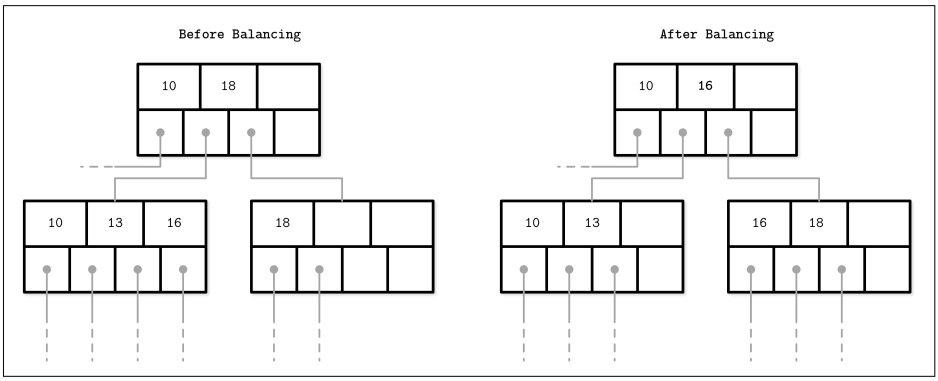

**Right-Only Appends**


Many database systems use auto-incremented monotonically increasing values as primary index keys. This case opens up an opportunity for an optimization, since all the insertions are happening toward the end of the index (in the rightmost leaf), so most of the splits occur on the rightmost node on each level. 

Moreover, since the keys are monotonically incremented, given that the ratio of appends versus updates and deletes is low, nonleaf pages are also less fragmented than in the case of randomly ordered keys.


**PostgreSQL** is calling this case a **fastpath**. When the inserted key is strictly greater than the first key in the rightmost page, and the rightmost page has enough space to hold the newly inserted entry, the new entry is inserted into the appropriate location in the cached rightmost leaf, and the whole read path can be skipped.

**SQLite** has a similar concept and calls it **quickbalance**. When the entry is inserted on the far right end and the target node is full (i.e., it becomes the largest entry in the tree upon insertion), instead of rebalancing or splitting the node, it allocates the new rightmost node and adds its pointer to the parent. Even though this leaves the newly created page nearly empty (instead of half empty in the case of a node split), it is very likely that the node will get filled up shortly

**Bulk Loading**


If we have presorted data and want to bulk load it, or have to rebuild the tree (for example, for defragmentation), we can take the idea with right-only appends even further. 

Since the data required for tree creation is already sorted, during bulk loading
we only need to append the items at the rightmost location in the tree. In this case, we can avoid splits and merges altogether and compose the tree from the bottom up, writing it out level by level, or writing out higher-level nodes as soon as we have enough pointers to already written lower-level nodes.

One approach for implementing bulk loading is to write presorted data on the leaf level page-wise (rather then inserting individual elements). After the leaf page is written, we propagate its first key to the parent and use a normal algorithm for building higher B-Tree levels. Since appended keys are given in the sorted order, all splits in this case occur on the rightmost node.

Since B-Trees are always built starting from the bottom (leaf) level, the complete leaf level can be written out before any higher-level nodes are composed. This allows having all child pointers at hand by the time the higher levels are constructed. The main benefits of this approach are that we do not have to perform any splits or merges on disk and, at the same time, have to keep only a minimal part of the tree (i.e., all parents of the currently filling leaf node) in memory for the time of construction.

**Compression**


Storing the raw, uncompressed data can induce significant overhead, and many databases offer ways to compress it to save space. The apparent trade-off here is between access speed and compression ratio: larger compression ratios can improve data size, allowing you to fetch more data in a single access, but might require more RAM and CPU cycles to compress and decompress it.

Compression can be done at different granularity levels. Even though compressing
entire files can yield better compression ratios, it has limited application as a whole file has to be recompressed on an update, and more granular compression is usually better-suited for larger datasets. 

Compressing an entire index file is both impractical and hard to implement efficiently: to address a particular page, the whole file (or its section containing compression metadata) has to be accessed (in order to locate a
compressed section), decompressed, and made available.


An alternative is to compress data page-wise. It fits our discussion well, since the algorithms we’ve been discussing so far use fixed-size pages. Pages can be compressed and uncompressed independently from one another, allowing you to couple compression with page loading and flushing. 

However, a compressed page in this case can occupy only a fraction of a disk block and, since transfers are usually done in units of disk blocks, it might be necessary to page in extra bytes.

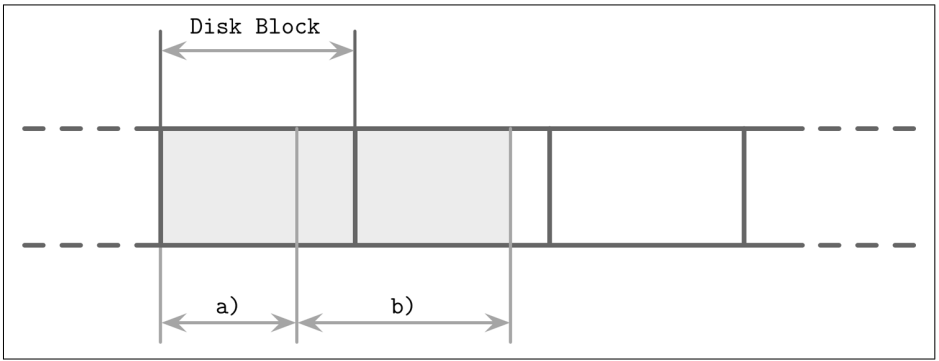

Another approach is to compress data only, either row-wise (compressing entire data records) or column-wise (compressing columns individually). In this case, page management and compression are decoupled.

Most of the open source databases reviewed have pluggable compression methods, using available libraries such as Snappy, zLib, lz4, and many others.

As compression algorithms yield different results depending on a dataset and potential objectives (e.g., compression ratio, performance, or memory overhead), we will not go into comparison and implementation details in this book. There are many overviews available that evaluate different compression algorithms for different block sizes (for example, Squash Compression Benchmark), usually focusing on four metrics: memory overhead, compression performance, decompression performance, and compression ratio. These metrics are important to consider when picking a compression library

**Vacuum and Maintenance**


So far we’ve been mostly talking about user-facing operations in B-Trees. However, there are other processes that happen in parallel with queries that 
* maintain storage integrity, 
* reclaim space, 
* reduce overhead, 
* keep pages in order. 

Performing these operations in the background allows us to save some time and avoid paying the price of cleanup during inserts, updates, and deletes.


The described design of slotted pages requires maintenance to be performed on pages to keep them in good shape. For example, subsequent splits and merges in internal nodes or inserts, updates, and deletes on the leaf level can result in a page that has enough logical space but does not have enough contiguous space, since it is fragmented.

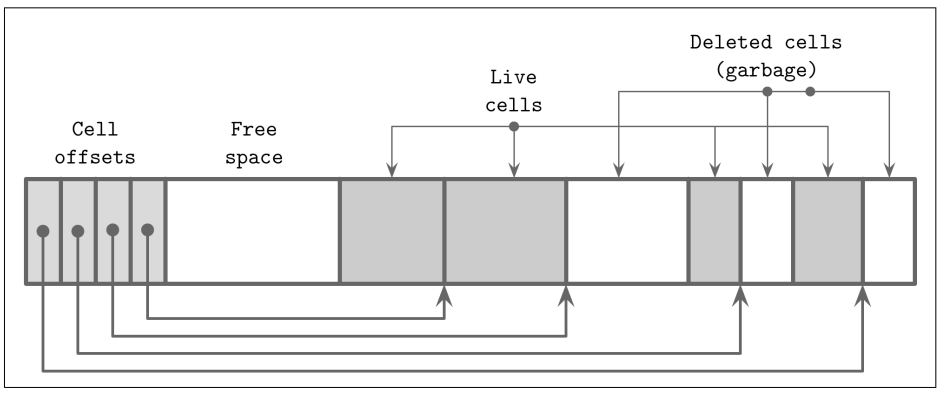

B-Trees are navigated from the root level. Data records that can be reached by following pointers down from the root node are live (addressable). 

Nonaddressable data records are said to be garbage: these records are not referenced anywhere and cannot be read or interpreted, so their contents are as good as nullified.

Zero-filling of garbage areas is often skipped for performance reasons, as eventually these areas are overwritten by the new data anyway.

**Fragmentation Caused by Updates and Deletes**


Let’s consider under which circumstances pages get into the state where they have nonaddressable data and have to be compacted. 

On the leaf level, deletes only remove cell offsets from the header, leaving the cell itself intact. After this is done, the cell is not addressable anymore, its contents will not appear in the query results, and nullifying it or moving neighboring cells is not necessary.

When the page is split, only offsets are trimmed and, since the rest of the page is not addressable, cells whose offsets were truncated are not reachable, so they will be overwritten whenever the new data arrives, or garbage-collected when the vacuum process kicks in.

Since deletes only discard cell offsets and do not relocate remaining cells or physically remove the target cells to occupy the freed space, freed bytes might end up scattered across the page. In this case, we say that the page is fragmented and requires defragmentation.

To make a write, we often need a contiguous block of free bytes where the cell fits. To put the freed fragments back together and fix this situation, we have to rewrite the page.

Insert operations leave tuples in their insertion order. This does not have as significant an impact, but having naturally sorted tuples can help with cache prefetch during sequential reads.

Updates are mostly applicable to the leaf level: internal page keys are used for guided navigation and only define subtree boundaries. Additionally, updates are performed on a per-key basis, and generally do not result in structural changes in the tree, apart from the creation of overflow pages. On the leaf level, however, update operations do not change cell order and attempt to avoid page rewrite. This means that multiple versions of the cell, only one of which is addressable, may end up being stored.

**Page Defragmentation**


The process that takes care of space reclamation and page rewrites is called compaction, vacuum, or just maintenance. 

Page rewrites can be done synchronously on write if the page does not have enough free physical space (to avoid creating unnecessary overflow pages), but compaction is mostly referred to as a distinct, asynchronous process of walking through pages, performing garbage collection, and rewriting their contents.

This process reclaims the space occupied by dead cells, and rewrites cells in their logical order. When pages are rewritten, they may also get relocated to new positions in the file. Unused in-memory pages become available and are returned to the page cache. IDs of the newly available on-disk pages are added to the free page list. This information has to be persisted to survive node crashes and restarts, and to make sure free space is not lost or leaked.